<a href="https://colab.research.google.com/github/AybTGH/Use_Case_Defect_Detection_in_Metal_Surfaces/blob/main/Use_Case_Defect_Detection_in_Metal_Surfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dowloading the data from kaggle: 

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d zhangyunsheng/defects-class-and-location

defects-class-and-location.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip defects-class-and-location.zip

Archive:  defects-class-and-location.zip
replace images/images/crease/img_01_3436789500_00004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: images/images/crease/img_01_3436789500_00004.jpg  
  inflating: images/images/crease/img_01_425382900_00002.jpg  
  inflating: images/images/crease/img_01_425501700_00022.jpg  
  inflating: images/images/crease/img_01_429539000_00002.jpg  
  inflating: images/images/crease/img_01_4402116900_00003.jpg  
  inflating: images/images/crease/img_01_4402117100_00006.jpg  
  inflating: images/images/crease/img_01_4402117200_00003.jpg  
  inflating: images/images/crease/img_01_4402270500_00003.jpg  
  inflating: images/images/crease/img_01_4402270500_00004.jpg  
  inflating: images/images/crease/img_01_4403690400_00005.jpg  
  inflating: images/images/crease/img_02_3436789500_00005.jpg  
  inflating: images/images/crease/img_02_425613700_00758.jpg  
  inflating: images/images/crease/img_02_4402116700_00002.jpg  
  inflating: images/images/crease

## Model creation

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
from matplotlib.patches import Rectangle
from lxml import etree

### **Data** **Preprocessing**

In [ ]:
image_path = glob.glob('./images/images/*/*.jpg')  #Return a list of path names that match pathname
len(image_path)

2306

In [ ]:
image_path[:3]

['./images/images/inclusion/img_07_425008500_00312.jpg',
 './images/images/inclusion/img_07_425506100_00205.jpg',
 './images/images/inclusion/img_03_4401440300_00347.jpg']

In [ ]:
xmls_path = glob.glob('./label/label/*.xml')
len(xmls_path)

2280

In [ ]:
xmls_path[:3]

['./label/label/img_08_425508100_01624.xml',
 './label/label/img_03_425503200_00018.xml',
 './label/label/img_05_4406743300_00391.xml']

In [ ]:
#xml_name extraction
xmls_train = [p.split('/')[-1].split('.')[0] for p in xmls_path]
xmls_train[:3]

['img_08_425508100_01624', 'img_03_425503200_00018', 'img_05_4406743300_00391']

In [ ]:
#img_name extraction: we will take just the images that are labeled
imgs_train = [img for img in image_path if (img.split('/')[-1].split)('.jpg')[0] in xmls_train]
imgs_train[:3]

['./images/images/inclusion/img_07_425008500_00312.jpg',
 './images/images/inclusion/img_07_425506100_00205.jpg',
 './images/images/inclusion/img_03_4401440300_00347.jpg']

In [ ]:
len(imgs_train),len(xmls_path)

(2280, 2280)

In [ ]:
# Sort the annotation and image files in ascending order: to match each image with the label
xmls_path.sort(key=lambda x:x.split('/')[-1].split('.xml')[0])
imgs_train.sort(key=lambda x:x.split('/')[-1].split('.jpg')[0])
xmls_path[:3],imgs_train[:3]

(['./label/label/img_01_3402617700_00001.xml',
  './label/label/img_01_3402617700_01009.xml',
  './label/label/img_01_3436789500_00004.xml'],
 ['./images/images/crescent_gap/img_01_3402617700_00001.jpg',
  './images/images/crescent_gap/img_01_3402617700_01009.jpg',
  './images/images/crease/img_01_3436789500_00004.jpg'])

In [ ]:
## Extract label names as DataFrame column
names = [x.split("/")[-2] for x in imgs_train]
names[:3]

['crescent_gap', 'crescent_gap', 'crease']

In [ ]:
names = pd.DataFrame(names,columns=['Types'])
names

,Types
0,crescent_gap
1,crescent_gap
2,crease
3,silk_spot
4,silk_spot
...,...
2275,silk_spot
2276,silk_spot
2277,silk_spot
2278,silk_spot


In [ ]:
#onehot for mutiple classes
from sklearn.preprocessing import LabelBinarizer
# Obtain training labels without duplication
Class = names['Types'].unique()
# Store data values in key:value pairs with Python dictionaries
Class_dict = dict(zip(Class, range(1,len(Class)+1)))
Class_dict

{'crease': 2,
 'crescent_gap': 1,
 'inclusion': 6,
 'oil_spot': 7,
 'punching_hole': 10,
 'rolled_pit': 9,
 'silk_spot': 3,
 'waist folding': 8,
 'water_spot': 4,
 'welding_line': 5}

In [ ]:
names['str'] = names['Types'].apply(lambda x: Class_dict[x]) # this column will help us to transforme the labels to binary values
lb = LabelBinarizer()
# Fit label binarizer
lb.fit(list(Class_dict.values()))
# Convert multi-class labels to binary labels (belong or does not belong to the class)
transformed_labels = lb.transform(names['str'])
transformed_labels

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_bin_labels = []  
for i in range(transformed_labels.shape[1]):
    y_bin_labels.append('str' + str(i))
    names['str' + str(i)] = transformed_labels[:, i]
names.drop('str',axis=1,inplace=True)
names.drop('Types',axis=1,inplace=True)
names.head()

,str0,str1,str2,str3,str4,str5,str6,str7,str8,str9
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [ ]:
#analysis rectangular box value in xmls
def to_labels(path):
    xml = open('{}'.format(path)).read()                 #read xml in path 
    sel = etree.HTML(xml)                     
    width = int(sel.xpath('//size/width/text()')[0])     #extract the width/height
    height = int(sel.xpath('//size/height/text()')[0])   # Extract the bounding box coordinates
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])     # this values will help us delimit the area (rectangle) of the defection in the image
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]   #return the four relative coordinates

In [ ]:
# Display the relative bounding box coordinates
labels = [to_labels(path) for path in xmls_path]
labels[:3]

[[0.8486328125, 0.806, 0.951171875, 0.993],
 [0.857421875, 0.298, 0.96044921875, 0.858],
 [0.47900390625, 0.182, 0.9990234375, 0.249]]

In [ ]:
#set four labels as outputs
out1,out2,out3,out4 = list(zip(*labels))        
#convert to np.array
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)
label = np.array(names.values)

In [ ]:
## Creates a Dataset whose elements are slices of the given tensors
# Slicing a 1D tensor produces scalar tensor elements
label_datasets = tf.data.Dataset.from_tensor_slices((out1,out2,out3,out4,label))
label_datasets

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.int64, name=None))>

In [ ]:
#def load_image function from image path
def load_image(path):
    image = tf.io.read_file(path)                           
    image = tf.image.decode_jpeg(image,3)               
    image = tf.image.resize(image,[224,224])               
    image = tf.cast(image/127.5-1,tf.float32)                 
    return image  


In [ ]:
#build dataset
dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
dataset = dataset.map(load_image)
dataset

<MapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
dataset_label = tf.data.Dataset.zip((dataset,label_datasets))
dataset_label

<ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.int64, name=None)))>

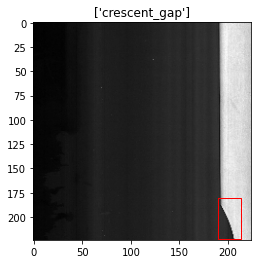

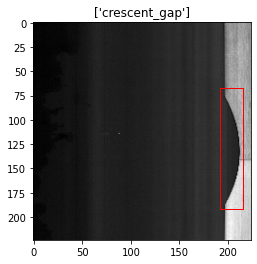

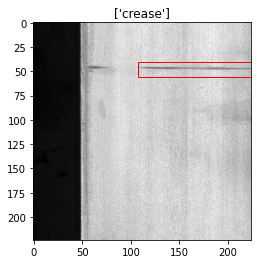

In [ ]:
# visualize data
species_dict = {v:k for k,v in Class_dict.items()}
for img, label in dataset_label.take(3):
    plt.imshow(keras.preprocessing.image.array_to_img(img))     
    out1,out2,out3,out4,out5 = label                            
    xmin,ymin,xmax,ymax = out1.numpy()*224,out2.numpy()*224,out3.numpy()*224,out4.numpy()*224
    rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='r')  
    ax = plt.gca()                      
    ax.axes.add_patch(rect)   
    pred_imglist = []
    pred_imglist.append(species_dict[np.argmax(out5)+1])
    plt.title(pred_imglist)
    plt.show()

### **Model Building**

In [ ]:
# Shuffle the images and extract the images by the defined batch size

batch_size = 64
dataset_label = dataset_label.repeat().shuffle(500).batch(batch_size)

# Creates a Dataset that prefetches elements from this dataset
# Most dataset input pipelines should end with a call to prefetch
# This allows later elements to be prepared while the current element is being processed
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements

dataset_label = dataset_label.prefetch(tf.data.experimental.AUTOTUNE)
dataset_label

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.int64, name=None)))>

In [ ]:
# Split the dataset into 80% for training and 20% for testing

train_count = int(len(imgs_train) * 0.8)
test_count = int(len(imgs_train) * 0.2)
train_count, test_count

(1824, 456)

In [ ]:
train_dataset = dataset_label.skip(test_count)
test_dataset = dataset_label.take(test_count)
train_dataset

<SkipDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.int64, name=None)))>

In [ ]:
conv = tf.keras.applications.ResNet50(
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg'
)

In [ ]:
#define Conv + FC structure
inputs = keras.Input(shape=(224,224,3))
x = conv(inputs)
x1 = keras.layers.Dense(128,activation='relu')(x)

out1 = keras.layers.Dense(1,name='out1')(x1)
out2 = keras.layers.Dense(1,name='out2')(x1)
out3 = keras.layers.Dense(1,name='out3')(x1)
out4 = keras.layers.Dense(1,name='out4')(x1)

out_class = keras.layers.Dense(10,activation='softmax',name='out_item')(x)

out = [out1,out2,out3,out4,out_class]

model = keras.models.Model(inputs=inputs,outputs=out)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 1000)         25636712    ['input_8[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 128)          128128      ['resnet50[0][0]']               
                                                                                                  
 out1 (Dense)                   (None, 1)            129         ['dense_7[0][0]']          

In [ ]:
#model compille
model.compile(keras.optimizers.Adam(0.0003),
              loss={'out1':'mse',
                    'out2':'mse',
                    'out3':'mse',
                    'out4':'mse',
                    'out_item':'categorical_crossentropy'},
              metrics=['mae','acc'])

In [ ]:
history = model.fit(train_dataset,
                   steps_per_epoch=train_count//batch_size,
                   epochs=20,
                   validation_data=test_dataset,
                   validation_steps=test_count//batch_size)





NameError: ignored

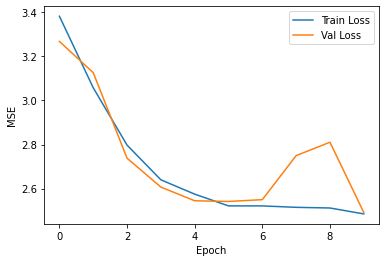

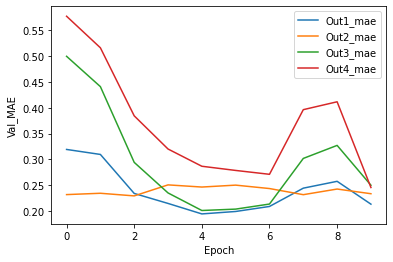

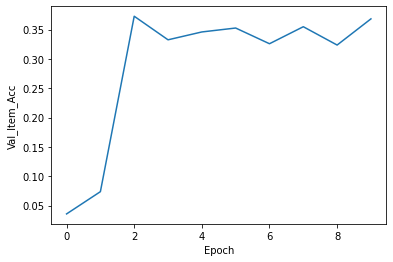

In [ ]:
#training visualization
def plot_history(history):                
    hist = pd.DataFrame(history.history)           
    hist['epoch']=history.epoch
    
    plt.figure()                                     
    plt.xlabel('Epoch')
    plt.ylabel('MSE')               
    plt.plot(hist['epoch'],hist['loss'],
            label='Train Loss')
    plt.plot(hist['epoch'],hist['val_loss'],
            label='Val Loss')                           
    plt.legend()
    
    plt.figure()                                      
    plt.xlabel('Epoch')
    plt.ylabel('Val_MAE')               
    plt.plot(hist['epoch'],hist['val_out1_mae'],
            label='Out1_mae')
    plt.plot(hist['epoch'],hist['val_out2_mae'],
            label='Out2_mae')
    plt.plot(hist['epoch'],hist['val_out3_mae'],
            label='Out3_mae')
    plt.plot(hist['epoch'],hist['val_out4_mae'],
            label='Out4_mae')
    plt.legend()      
    
    plt.figure()                                      
    plt.xlabel('Epoch')
    plt.ylabel('Val_Item_Acc')               
    plt.plot(hist['epoch'],hist['val_out_item_acc'],
            label='Out5_acc')
    
    plt.show()
    
plot_history(history)      

In [ ]:
model.save("class_location.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


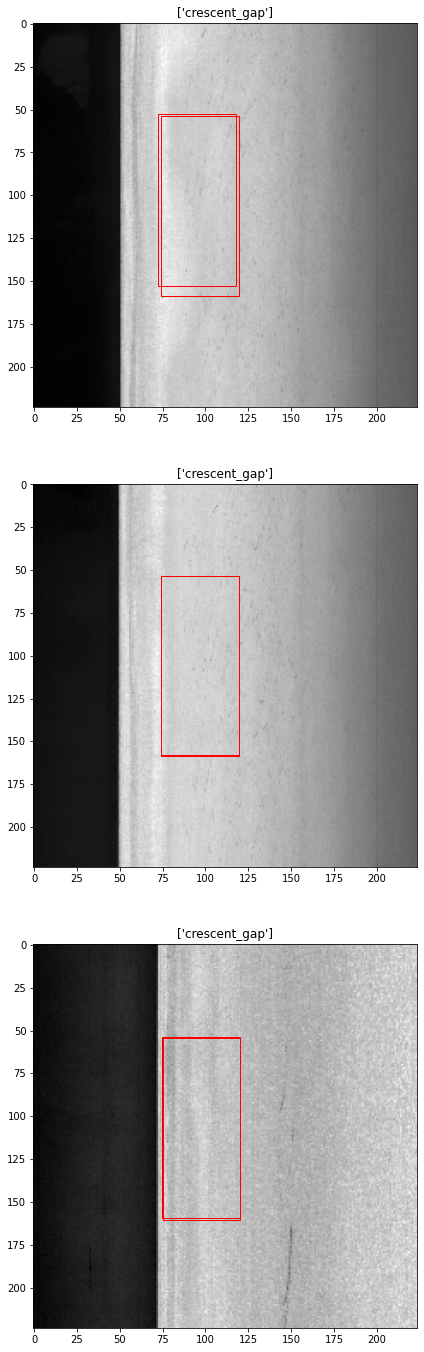

In [ ]:
plt.figure(figsize=(10,24))
for img,_ in train_dataset.take(2):
    out1,out2,out3,out4,label = model.predict(img)
    for i in range(3):
        plt.subplot(3,1,i+1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))    
        pred_imglist = []
        pred_imglist.append(species_dict[np.argmax(out5[i])+1])
        plt.title(pred_imglist)
        xmin,ymin,xmax,ymax = out1[i]*224,out2[i]*224,out3[i]*224,out4[i]*224
        rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='r') 
        ax = plt.gca()                   
        ax.axes.add_patch(rect)       

The results are not satisfying and we can see clearly that the accuracy is low so i need to change the hyper-parameters ( number of layers and neurons and some other parameters ). Although it will take some time to get the best results. 